# IST 707 - HW2

## Step 1 - Data Preparation & Exploratory Data Analysis


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.tree import DecisionTreeClassifier

#### Import data from Google Drive

In [168]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [169]:
%%bash
pip install seaborn



In [0]:
DATASET_PATH = 'gdrive/My Drive/Nisha/MS_ADS/DA/'
TRAIN_PATH = DATASET_PATH + 'weather_forecast_train.csv'
TEST_PATH = DATASET_PATH + 'weather_forecast_test.csv'

OUTPUT_COL = 'RainTomorrow'
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_test_copy = df_test

In [171]:
df_train.shape

(51978, 16)

In [172]:
df_test.shape

(12994, 16)

In [173]:
df_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp
count,51694.000000,51849.000000,51231.000000,29425.000000,27103.000000,48407.000000,50954.000000,50549.000000,46912.000000,31848.000000,50915.000000
mean,12.549174,22.512698,3.639494,5.177570,6.530580,42.003016,19.092299,57.432214,1014.273338,5.175647,20.845623
std,6.376746,7.113064,11.009628,4.017662,3.946561,14.627024,9.157505,21.833045,7.278733,2.632166,6.938471
min,-8.000000,-4.100000,0.000000,0.000000,0.000000,7.000000,0.000000,1.000000,977.100000,0.000000,-4.400000
25%,7.900000,17.200000,0.000000,2.400000,3.200000,31.000000,13.000000,42.000000,1009.300000,3.000000,15.700000
50%,12.300000,21.800000,0.000000,4.400000,6.900000,39.000000,19.000000,58.000000,1014.200000,6.000000,20.200000
75%,17.200000,27.500000,2.200000,7.000000,9.900000,50.000000,24.000000,73.000000,1019.200000,7.000000,25.600000
max,31.400000,47.000000,371.000000,77.300000,14.500000,135.000000,83.000000,100.000000,1037.800000,8.000000,46.100000


In [174]:
df_train.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,NaN,NaN,SSE,41.0,SSE,28.0,55.0,1026.0,NaN,22.4,No,Yes
1,Nuriootpa,11.1,20.8,0.0,4.8,8.3,W,39.0,WSW,26.0,48.0,1014.4,7.0,19.5,No,No
2,GoldCoast,15.9,19.5,17.6,NaN,NaN,SE,44.0,SW,9.0,99.0,1028.5,NaN,17.8,Yes,Yes
3,Bendigo,0.0,14.9,0.0,NaN,NaN,WSW,35.0,WNW,19.0,55.0,1023.0,4.0,14.2,No,Yes
4,Walpole,9.1,22.7,0.0,NaN,NaN,NNE,41.0,ESE,7.0,40.0,1027.1,NaN,22.5,No,No
5,MelbourneAirport,6.6,16.3,8.4,3.4,6.9,S,50.0,S,30.0,55.0,1021.4,7.0,14.6,Yes,No
6,Mildura,9.7,20.6,0.0,1.0,4.2,WNW,61.0,NW,20.0,35.0,1015.8,7.0,19.5,No,No
7,Williamtown,17.1,21.9,134.8,NaN,0.0,SSE,54.0,SSE,28.0,99.0,1012.0,8.0,17.9,Yes,Yes
8,Watsonia,13.5,23.5,0.0,6.8,6.5,NW,46.0,NE,19.0,53.0,1018.2,6.0,22.2,No,Yes
9,Nhil,12.5,21.3,0.0,NaN,NaN,W,65.0,W,22.0,82.0,1002.6,NaN,13.1,No,Yes


In [175]:
df_train.isna().sum()

Location             0
MinTemp            284
MaxTemp            129
Rainfall           747
Evaporation      22553
Sunshine         24875
WindGustDir       3598
WindGustSpeed     3571
WindDir           1513
WindSpeed         1024
Humidity          1429
Pressure          5066
Cloud            20130
Temp              1063
RainToday          747
RainTomorrow         0
dtype: int64

In [176]:
df_test.isna().sum()

ID                  0
Location            0
MinTemp            47
MaxTemp            18
Rainfall          161
Evaporation      5516
Sunshine         6094
WindGustDir       929
WindGustSpeed     920
WindDir           387
WindSpeed         261
Humidity          349
Pressure         1293
Cloud            5020
Temp              267
RainToday         161
dtype: int64

### Handling issues with data quality:

#### We can see from above result that we have a lot of missing data.
#### To deal with numerical missing data, I have grouped each field based on its location and replaced values accordingly. 
#### If there does not exist any value for a particular location, then I replaced the corresponding field with mean of the whole column.

In [0]:
def cleanNumericalData(df):
    for column in df:
        if df[column].dtypes != 'object':
            overallMean = df[column].mean()
            df[column] = df.groupby("Location")[column].transform(lambda a: a.fillna(overallMean) if np.isnan(a.mean()) else a.fillna(a.mean()))

In [0]:
cleanNumericalData(df_train)

In [179]:
df_train.isna().sum()

Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      3598
WindGustSpeed       0
WindDir          1513
WindSpeed           0
Humidity            0
Pressure            0
Cloud               0
Temp                0
RainToday         747
RainTomorrow        0
dtype: int64

In [0]:
cleanNumericalData(df_test)

In [181]:
df_test.isna().sum()

ID                 0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir      929
WindGustSpeed      0
WindDir          387
WindSpeed          0
Humidity           0
Pressure           0
Cloud              0
Temp               0
RainToday        161
dtype: int64

#### We can observe from above result that we don't have any other missing numerical data.

#### Let us explore each of the numerical attributes before proceeding to clean categorical data.

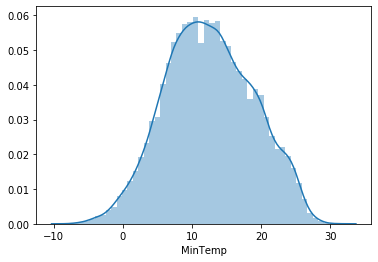

In [182]:
import seaborn as sns
sns.distplot(df_train['MinTemp'])

#### Create bins to get a better visualization!

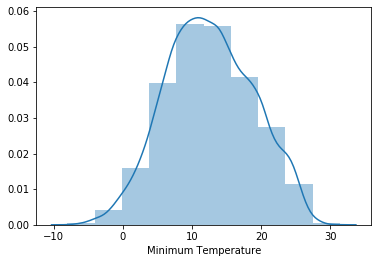

In [183]:
sns.distplot(df_train['MinTemp'], axlabel="Minimum Temperature",bins=10)

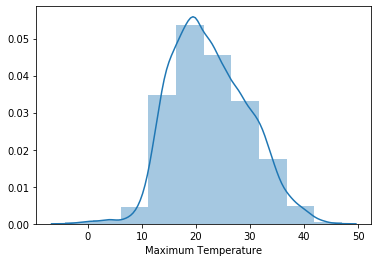

In [184]:
sns.distplot(df_train['MaxTemp'], axlabel="Maximum Temperature", bins=10)

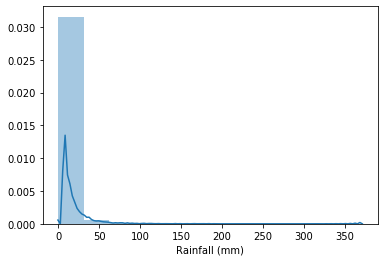

In [185]:
sns.distplot(df_train['Rainfall'], axlabel="Rainfall (mm)", bins=12)

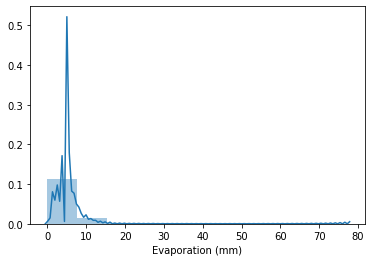

In [186]:
sns.distplot(df_train['Evaporation'], axlabel="Evaporation (mm)", bins=10)

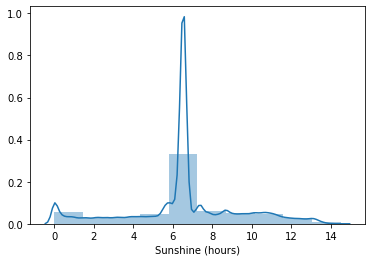

In [187]:
sns.distplot(df_train['Sunshine'], axlabel="Sunshine (hours)", bins=10)

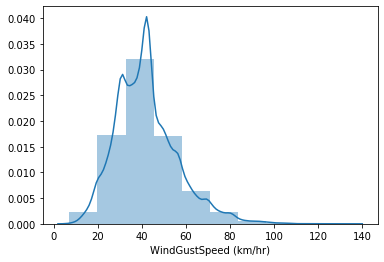

In [188]:
sns.distplot(df_train['WindGustSpeed'], axlabel="WindGustSpeed (km/hr)", bins=10)

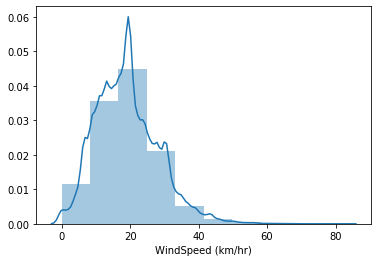

In [189]:
sns.distplot(df_train['WindSpeed'], axlabel="WindSpeed (km/hr)", bins=10)

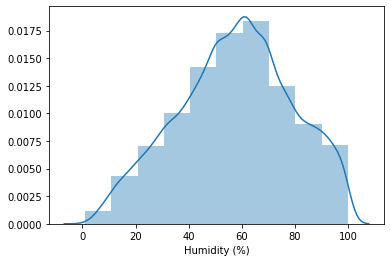

In [190]:
sns.distplot(df_train['Humidity'], axlabel="Humidity (%)", bins=10)

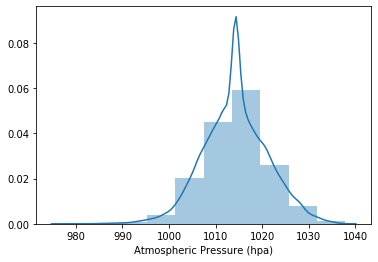

In [191]:
sns.distplot(df_train['Pressure'], axlabel="Atmospheric Pressure (hpa)", bins=10)

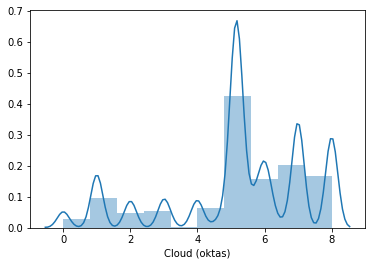

In [192]:
sns.distplot(df_train['Cloud'], axlabel="Cloud (oktas)", bins=10)

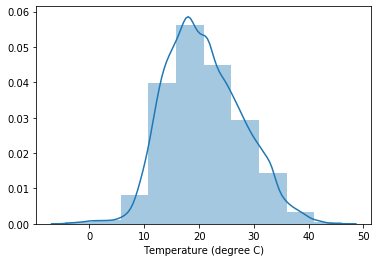

In [193]:
sns.distplot(df_train['Temp'], axlabel="Temperature (degree C)", bins=10)

#### For categorical attributes, we have 12 distinct values in WindGustDir and WindDir individually. We could perform one hot encoding, but that would result in 24 additional columns.

#### Thus, deleting categorical attributes for these 2 columns.


#### For RainToday attribute, I am replacing the Nulls with mode RainToday value.

In [0]:
df_train.drop(labels=['WindGustDir', 'WindDir'], axis=1, inplace=True)
df_test.drop(labels=['WindGustDir', 'WindDir'], axis=1, inplace=True)


In [0]:
overallMode = df_train['RainToday'].mode()

In [0]:
df_train['RainToday'] = df_train['RainToday'].fillna(overallMode[0])

In [197]:
df_train.isna().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed        0
Humidity         0
Pressure         0
Cloud            0
Temp             0
RainToday        0
RainTomorrow     0
dtype: int64

In [198]:
df_test.isna().sum()

ID                 0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustSpeed      0
WindSpeed          0
Humidity           0
Pressure           0
Cloud              0
Temp               0
RainToday        161
dtype: int64

In [0]:
overallModeTest = df_test['RainToday'].mode()


In [0]:
df_test['RainToday'] = df_test['RainToday'].fillna(overallModeTest[0])

In [201]:
df_test.isna().sum()

ID               0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed        0
Humidity         0
Pressure         0
Cloud            0
Temp             0
RainToday        0
dtype: int64

#### As you can see from above result, all our missing values are handled.

#### However, to perform clustering, we need numerical data, and so we need to convert attributes RainToday & RainTomorrow to numerical form. I used LabelBinarizer to do the above task - which converts Yes to 1 and No to 0.

#### Also, since location is no more useful, we can drop location attribute.

In [202]:
lb = LabelBinarizer()
df_train['RainToday'] = lb.fit_transform(df_train['RainToday'])
df_train['RainTomorrow'] = lb.fit_transform(df_train['RainTomorrow'])
df_test['RainToday'] = lb.fit_transform(df_test['RainToday'])

df_train.head(10)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
0,NorahHead,18.9,23.7,0.0,5.177570,6.53058,41.0,28.0,55.0,1026.0,5.175647,22.4,0,1
1,Nuriootpa,11.1,20.8,0.0,4.800000,8.30000,39.0,26.0,48.0,1014.4,7.000000,19.5,0,0
2,GoldCoast,15.9,19.5,17.6,5.177570,6.53058,44.0,9.0,99.0,1028.5,5.175647,17.8,1,1
3,Bendigo,0.0,14.9,0.0,3.697044,6.53058,35.0,19.0,55.0,1023.0,4.000000,14.2,0,1
4,Walpole,9.1,22.7,0.0,5.177570,6.53058,41.0,7.0,40.0,1027.1,5.175647,22.5,0,0
5,MelbourneAirport,6.6,16.3,8.4,3.400000,6.90000,50.0,30.0,55.0,1021.4,7.000000,14.6,1,0
6,Mildura,9.7,20.6,0.0,1.000000,4.20000,61.0,20.0,35.0,1015.8,7.000000,19.5,0,0
7,Williamtown,17.1,21.9,134.8,6.471171,0.00000,54.0,28.0,99.0,1012.0,8.000000,17.9,1,1
8,Watsonia,13.5,23.5,0.0,6.800000,6.50000,46.0,19.0,53.0,1018.2,6.000000,22.2,0,1
9,Nhil,12.5,21.3,0.0,5.177570,6.53058,65.0,22.0,82.0,1002.6,5.175647,13.1,0,1


In [203]:
df_test.head(10)

,ID,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
0,1,Perth,15.3,21.5,4.4,2.40000,1.400000,70.0,22.0,69.0,997.6,7.000000,19.8,1
1,2,Portland,7.1,11.0,38.8,1.20000,5.800000,48.0,19.0,46.0,1014.0,4.000000,10.7,1
2,3,Hobart,3.6,16.6,0.2,2.80000,9.300000,37.0,15.0,48.0,1016.6,5.000000,15.4,0
3,4,Woomera,17.6,37.4,0.0,34.00000,8.340426,37.0,19.0,11.0,1010.4,2.000000,34.6,0
4,5,Townsville,11.4,25.6,0.0,6.00000,2.800000,31.0,13.0,52.0,1016.4,7.000000,24.3,0
5,6,Nuriootpa,4.4,13.0,0.4,1.80000,5.100000,39.0,17.0,69.0,1013.6,6.000000,11.3,0
6,7,Watsonia,12.4,22.4,0.6,3.20000,4.800000,20.0,4.0,57.0,1020.8,3.000000,21.6,0
7,8,Watsonia,8.3,14.1,1.0,2.40000,7.100000,56.0,22.0,58.0,1021.1,7.000000,13.6,0
8,9,Moree,22.8,38.6,0.0,12.00000,9.300000,54.0,11.0,31.0,1001.7,6.000000,37.1,0
9,10,Albury,18.0,26.9,0.2,5.14893,6.577928,46.0,22.0,31.0,1005.2,6.131737,25.9,0


#### Perform data standardization and data normalization

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()

In [205]:
df_train['RainToday'].astype(int)
df_test['RainToday'].astype(int)
df_train['RainTomorrow'].astype(int)


0        1
1        0
2        1
3        1
4        0
        ..
51973    1
51974    1
51975    1
51976    0
51977    0
Name: RainTomorrow, Length: 51978, dtype: int64

In [0]:
df_train.drop(labels=['Location'], axis=1, inplace=True)
df_test.drop(labels=['Location'], axis=1, inplace=True)

np_scaled_train = min_max_scaler.fit_transform(df_train)
np_scaled_test = min_max_scaler.fit_transform(df_test)

In [0]:
df_normalized_train = pd.DataFrame(np_scaled_train, columns=df_train.columns, index=df_train.index)
df_normalized_test = pd.DataFrame(np_scaled_test, columns=df_test.columns, index=df_test.index)

In [208]:
df_normalized_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday,RainTomorrow
count,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000,51978.000000
mean,0.521605,0.520797,0.009815,0.067023,0.451025,0.273638,0.229373,0.571218,0.612215,0.652449,0.500269,0.301801,0.490958
std,0.161611,0.139092,0.029466,0.039698,0.197575,0.110341,0.109556,0.218155,0.113995,0.260079,0.137575,0.459044,0.499923
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.406091,0.416830,0.000000,0.047827,0.402022,0.187500,0.156627,0.424242,0.540362,0.625000,0.400000,0.000000,0.000000
50%,0.515228,0.506849,0.000000,0.066980,0.450385,0.265625,0.228916,0.585859,0.612411,0.646956,0.487129,0.000000,0.000000
75%,0.639594,0.618395,0.006469,0.075032,0.517241,0.335938,0.289157,0.727273,0.683690,0.875000,0.594059,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [209]:
df_normalized_test.describe()

,ID,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed,Humidity,Pressure,Cloud,Temp,RainToday
count,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000,12994.000000
mean,0.500000,0.524865,0.517642,0.009938,0.059206,0.470168,0.273829,0.218482,0.568862,0.596288,0.645670,0.496141,0.302447
std,0.288708,0.176258,0.140236,0.029826,0.035838,0.205745,0.111072,0.105129,0.218424,0.121563,0.262058,0.137890,0.459336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.400552,0.415020,0.000000,0.041763,0.421501,0.187500,0.149425,0.416667,0.521053,0.613994,0.397614,0.000000
50%,0.500000,0.516575,0.501976,0.000000,0.059732,0.469852,0.265625,0.218391,0.575758,0.596504,0.639249,0.483101,0.000000
75%,0.750000,0.651934,0.614625,0.006529,0.062645,0.546657,0.335938,0.275862,0.727273,0.671930,0.875000,0.586481,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Section 2 - Cluster Analysis & Decision Tree Modeling

#### Since we do not have the actual prediction output for testing set, I will initially split the training data in 80-20% to test how the models are performing.


In [0]:
OUTPUT_COL = 'RainTomorrow'
df_X = df_train.loc[:, df_train.columns != OUTPUT_COL]
df_y = df_train[OUTPUT_COL]

df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(df_X, df_y, test_size=0.2, random_state=47)

#### In order to use unsupervised learning algorithms like clustering for classifying data, while training - I am creating 2 clusters and finding out majority label from both clusters and that would the final label for that cluster. While testing, I used the above model to add testing data points to above created cluster - if that row falls in the cluster that is labeled as 'Yes' - then it'll be predicted to rain for that row.

#### Creating reusable functions below to get majority label and classify data from the 2 clusters (for both Kmeans and HAC).

In [0]:
def get_majority_labels(cluster_labels, df_true_labels):
  cluster_0_rain, cluster_0_no_rain = 0, 0
  cluster_1_rain, cluster_1_no_rain = 0, 0

  for i in range(len(cluster_labels)):
    if df_true_labels.iloc[i] == 1:
      if cluster_labels[i] == 0:
        cluster_0_rain += 1
      else:
        cluster_1_rain += 1
    else:
      if cluster_labels[i] == 0:
        cluster_0_no_rain += 1
      else:
        cluster_1_no_rain += 1
  cluster_0_majority = 1 if cluster_0_rain > cluster_0_no_rain else 0
  cluster_1_majority = 1 if cluster_1_rain > cluster_1_no_rain else 0
  return cluster_0_majority, cluster_1_majority


def classify_by_cluster(label0, label1, cluster_labels):
  class_out = []
  for label in cluster_labels:
    if label == 0:
      class_out.append(label0)
    else:
      class_out.append(label1)
  return class_out

In [212]:
kmeans = KMeans(n_clusters=2, random_state=47).fit(df_train_X)
kmeans_label0, kmeans_label1 = get_majority_labels(kmeans.labels_, df_train_y)

val_pred_kmeans = classify_by_cluster(kmeans_label0, kmeans_label1, kmeans.predict(df_val_X))
print(accuracy_score(df_val_y, val_pred_kmeans))

0.7213351288957291


#### Since we're dealing with Weather forecasting problem, I'll go ahead with measuring Recall for model evaluation, as to predict if it'll rain, we can afford to have False positives. False negatives (predicting that it will not rain, but it ends up raining on that day) is more harmful here.

#### Also, it also correct to measure accuracy score as we half almost equal number of Yes and No labels in the training set.

In [213]:
print(recall_score(df_val_y, val_pred_kmeans))

0.7718571146635089


#### Now that we know our model's accuracy and recall, lets take the complete training dataset and predict weather for testing set.

In [0]:
df_IDs = df_test['ID']
df_test_Final = df_test.loc[:, df_test.columns != 'ID']

kmeansFinal = KMeans(n_clusters=2, random_state=47).fit(df_X)
kmeansF_label0, kmeansF_label1 = get_majority_labels(kmeansFinal.labels_, df_y)

val_pred_kmeansFinal = classify_by_cluster(kmeansF_label0, kmeansF_label1, kmeansFinal.predict(df_test_Final))

#### HAC

In [215]:
df_merged = pd.concat([df_train_X, df_val_X])

hac = AgglomerativeClustering(n_clusters=2).fit(df_merged)
hac_labels = hac.labels_
hac_labels_train = hac_labels[:len(df_train_X)]
hac_label0, hac_label1 = get_majority_labels(hac_labels_train, df_train_y)

hac_labels_val = hac_labels[-len(df_val_X):]
val_pred_hac = classify_by_cluster(hac_label0, hac_label1, hac_labels_val)
print(accuracy_score(df_val_y, val_pred_hac))

0.5980184686417853


In [216]:
print(recall_score(df_val_y, val_pred_hac))

0.9301361752516282


#### Predict for testing set using HAC

In [0]:
df_merged = pd.concat([df_train_X, df_val_X])

hac = AgglomerativeClustering(n_clusters=2).fit(df_merged)
hac_labels = hac.labels_
hac_labels_train = hac_labels[:len(df_train_X)]
hac_label0, hac_label1 = get_majority_labels(hac_labels_train, df_train_y)

hac_labels_val = hac_labels[-len(df_test_Final):]
val_pred_hac = classify_by_cluster(hac_label0, hac_label1, hac_labels_val)

#### Decision Tree

In [218]:
dtc = DecisionTreeClassifier(random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes= 56).fit(df_train_X, df_train_y)

val_pred_dtc = dtc.predict(df_val_X)
print(accuracy_score(df_val_y, val_pred_dtc))

0.7680838784147749


In [219]:
print(recall_score(df_val_y, val_pred_dtc))

0.7394908229721728


#### Hyperparameters tuning
#### [Combination : Accuracy]
#### 1. random_state = 47 : 70.98%
#### 2. random_state =47, splitter="random" : 69.6%
#### 3. random_state =47, criterion="gini" : 70.98%
#### 4. random_state =47, criterion="entropy" : 70.99%
#### 5. random_state =47, criterion="gini", min_samples_split = 2 : 70.98%
#### 6. random_state =47, criterion="gini", min_samples_split = 7 : 71.01%
#### 7. random_state =47, criterion="gini", min_samples_split = 9 : 71.18%
#### 8. random_state =47, criterion="gini", min_samples_split = 10 : 71.11%
#### 9. random_state=47, criterion="entropy", min_samples_split=9, max_depth=5 : 75.9%
#### 10. random_state=47, criterion="entropy", min_samples_split=9, max_depth=6 : 76.3%
#### 11. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8 : 76.5%
#### 12. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=1 : 76.5%
#### 13. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6 : 76.6%
#### 14. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes = 2 : 72.3%
#### 14. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes = 8 : 73.5%
#### 14. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes = 40 : 76.54%
#### 14. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes = 48 : 76.73%
#### 14. random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes = 56 : 76.81%


#### Now that we know our model's accuracy & recall, lets take the complete training dataset and predict weather for testing set.

In [0]:
dtcFin = DecisionTreeClassifier(random_state=47, criterion="entropy", min_samples_split=9, max_depth=8, min_samples_leaf=6, max_leaf_nodes= 56).fit(df_X, df_y)

val_pred_dtc_final = dtcFin.predict(df_test_Final)

#### We got better results from Decision tree classifier than using KMeans, which did better than HAC. 
#### We can use clustering to perform classification, but classification algorithms perform better than clustering algorithms when it comes to classifying data.

#### ROC-AUC for decision tree


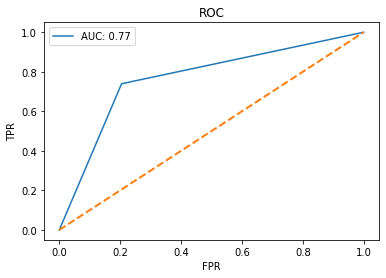

In [221]:
fpr, tpr, threshold = roc_curve(df_val_y, val_pred_dtc)
plt.plot(fpr, tpr, label='AUC: %0.2f' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], '--', lw=2)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

#### Area Under Curve (AUC) = 0.77

In [0]:

final = {
    'ID' : df_test_copy.ID,
    'kmeans' : val_pred_kmeansFinal,
    'HAC' : val_pred_hac,
    'DT' : val_pred_dtc_final
}
final_df = pd.DataFrame(final)
final_df.to_csv('FinalOutput.csv')